In [1]:
from maze_env import Maze
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import glob
import pickle

def get_latest_folder(base_name):
    index = 1
    while True:
        folder = f"{base_name}_{index}"
        if not os.path.exists(folder):
            folder = f"{base_name}_{index-1}"
            return folder
        index += 1
folder = get_latest_folder("world")

from maze_PTR_model import MazePTRModel
model = MazePTRModel()
checkpoint = torch.load(f"{folder}/models/last_model.pt")
model.load_state_dict(checkpoint)
model.eval()

# iterations
iters = 50000
initial_epsilon = 1.0
eps_anneal_rate = 0.3
alpha= 0.5
gamma = 0.99
eval_episodes = 1000
eval_steps = 100

move_penalty = 0.0

In [2]:
#Create new env with estimated reward and train agent
shrink_factor = 10
env_1 = Maze(sparse=False, model=model, move_penalty=move_penalty)
#Q_2 = env_2.value_iter2(iters=iters, alpha=alpha,gamma=gamma,initial_eps=initial_epsilon, eps_anneal_rate=eps_anneal_rate,disp=True,plot_freq=1000)

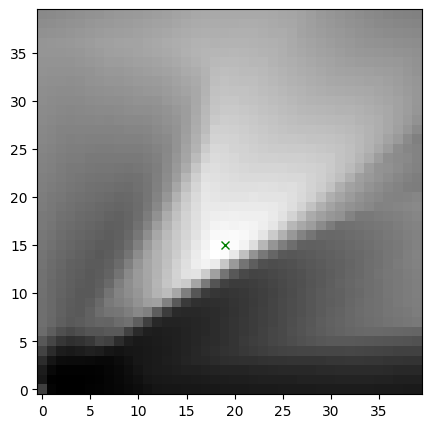

In [3]:
env_2 = Maze(sparse=False, model=model, move_penalty=move_penalty)
env_2.shrink_reward(shrink_factor/4)
env_2.plot_reward()
#Q_3 = env_3.value_iter2(iters=iters, alpha=alpha,gamma=gamma,initial_eps=initial_epsilon, eps_anneal_rate=eps_anneal_rate,disp=True,plot_freq=1000)


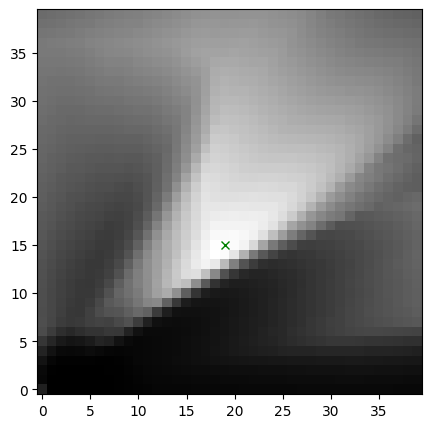

In [4]:

env_3 = Maze(sparse=False, model=model, move_penalty=move_penalty)
env_3.shrink_reward(shrink_factor/2)
env_3.plot_reward()
#Q_4 = env_4.value_iter2(iters=iters, alpha=alpha,gamma=gamma,initial_eps=initial_epsilon, eps_anneal_rate=eps_anneal_rate,disp=True,plot_freq=1000)


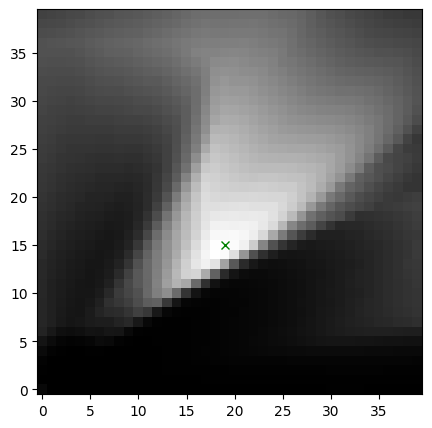

In [5]:

env_4 = Maze(sparse=False, model=model, move_penalty=move_penalty)
env_4.shrink_reward(shrink_factor)
env_4.plot_reward()
#Q_5 = env_5.value_iter2(iters=iters, alpha=alpha,gamma=gamma,initial_eps=initial_epsilon, eps_anneal_rate=eps_anneal_rate,disp=True,plot_freq=1000)

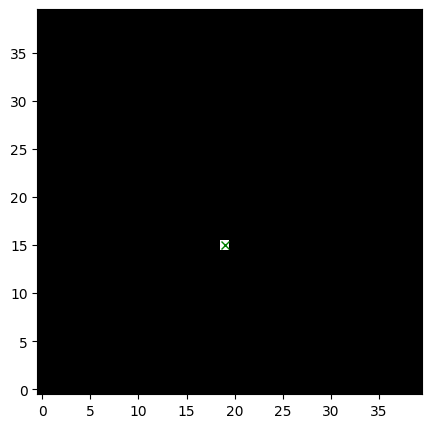

In [6]:
#Create new env with estimated reward and train agent
env_5 = Maze(sparse=True, move_penalty=move_penalty)
env_5.plot_reward()
#Q_1 = env_1.value_iter2(iters=iters, alpha=alpha,gamma=gamma,initial_eps=initial_epsilon, eps_anneal_rate=eps_anneal_rate,disp=True,plot_freq=1000)

In [7]:
# train agent on all envs, evaluate performance every 10 episodes, produce 5 arrays of performances and plot
num_episodes = 3000
eval_frequency = 20
episode_length = 1000
e = 0.3
s = 200
eps = np.arange(0, num_episodes, eval_frequency)
performance_1 = np.zeros(len(eps))
performance_2 = np.zeros(len(eps))
performance_3 = np.zeros(len(eps))
performance_4 = np.zeros(len(eps))
performance_5 = np.zeros(len(eps)) 
Q_1 = np.ones((env_1.Nx*env_1.Ny,env_1.action_space.shape[0]))
Q_2 = np.ones((env_2.Nx*env_2.Ny,env_2.action_space.shape[0]))
Q_3 = np.ones((env_3.Nx*env_3.Ny,env_3.action_space.shape[0]))
Q_4 = np.ones((env_4.Nx*env_4.Ny,env_4.action_space.shape[0]))
Q_5 = np.ones((env_5.Nx*env_5.Ny,env_5.action_space.shape[0]))
for i in range(len(eps)):
    print(f"batch {i}, learning Q")
    Q_1 = env_1.train_Q_1_epoch(episodes=eval_frequency, init_Q=Q_1, episode_length=episode_length, alpha=alpha,gamma=gamma,final_greediness=0.5, eps_anneal=True,disp=False)
    Q_2 = env_2.train_Q_1_epoch(episodes=eval_frequency, init_Q=Q_2, episode_length=episode_length, alpha=alpha,gamma=gamma,final_greediness=0.5, eps_anneal=True,disp=False)
    Q_3 = env_3.train_Q_1_epoch(episodes=eval_frequency, init_Q=Q_3, episode_length=episode_length, alpha=alpha,gamma=gamma,final_greediness=0.5, eps_anneal=True,disp=False)
    Q_4 = env_4.train_Q_1_epoch(episodes=eval_frequency, init_Q=Q_4, episode_length=episode_length, alpha=alpha,gamma=gamma,final_greediness=0.5, eps_anneal=True,disp=False)
    Q_5 = env_5.train_Q_1_epoch(episodes=eval_frequency, init_Q=Q_5, episode_length=episode_length, alpha=alpha,gamma=gamma,final_greediness=0.5, eps_anneal=True,disp=False)
    print(f"batch {i}, evaluating performance") 
    performance_1[i] = env_1.evaluate_Q(Q=Q_1, episodes=20, episode_length=s, final_greediness=1-e, eps_anneal=False)
    performance_2[i] = env_2.evaluate_Q(Q=Q_2, episodes=20, episode_length=s, final_greediness=1-e, eps_anneal=False)
    performance_3[i] = env_3.evaluate_Q(Q=Q_3, episodes=20, episode_length=s, final_greediness=1-e, eps_anneal=False)
    performance_4[i] = env_4.evaluate_Q(Q=Q_4, episodes=20, episode_length=s, final_greediness=1-e, eps_anneal=False)
    performance_5[i] = env_5.evaluate_Q(Q=Q_5, episodes=20, episode_length=s, final_greediness=1-e, eps_anneal=False)


batch 0, learning Q
batch 0, evaluating performance
batch 1, learning Q
batch 1, evaluating performance
batch 2, learning Q
batch 2, evaluating performance
batch 3, learning Q
batch 3, evaluating performance
batch 4, learning Q
batch 4, evaluating performance
batch 5, learning Q
batch 5, evaluating performance
batch 6, learning Q
batch 6, evaluating performance
batch 7, learning Q
batch 7, evaluating performance
batch 8, learning Q
batch 8, evaluating performance
batch 9, learning Q
batch 9, evaluating performance
batch 10, learning Q
batch 10, evaluating performance
batch 11, learning Q
batch 11, evaluating performance
batch 12, learning Q
batch 12, evaluating performance
batch 13, learning Q
batch 13, evaluating performance
batch 14, learning Q
batch 14, evaluating performance
batch 15, learning Q
batch 15, evaluating performance
batch 16, learning Q
batch 16, evaluating performance
batch 17, learning Q
batch 17, evaluating performance
batch 18, learning Q
batch 18, evaluating perfor

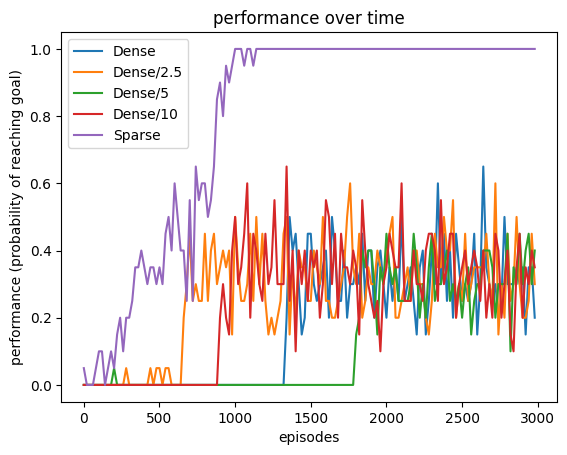

In [8]:
# plot the results
plt.figure()
plt.plot(eps, performance_1, label="Dense")
plt.plot(eps, performance_2, label="Dense/2.5")
plt.plot(eps, performance_3, label="Dense/5")
plt.plot(eps, performance_4, label="Dense/10")
plt.plot(eps, performance_5, label="Sparse")
plt.xlabel("episodes")
plt.ylabel("performance (probability of reaching goal)")
plt.title("performance over time")
plt.legend()
plt.savefig(f"{folder}/figs/eval_over_time.png")
plt.show()

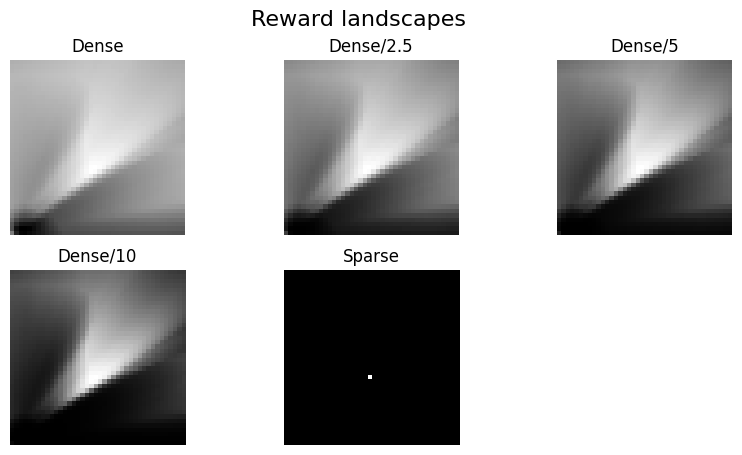

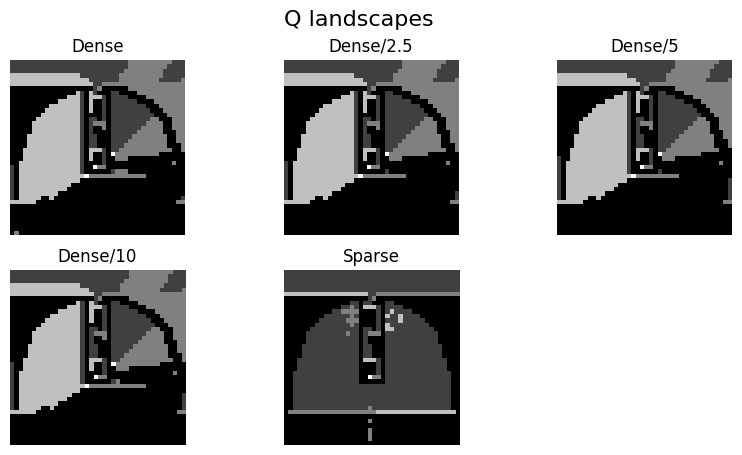

In [9]:
# create side by side subplots of the 5 reward functions
plt.figure(figsize=(10,5))
plt.suptitle("Reward landscapes", fontsize=16)
plt.subplot(2,3,1)
plt.imshow(env_1.reward_landscape.T, origin='lower', cmap='gray')
# hide the axes
plt.axis('off')
plt.title("Dense")
plt.subplot(2,3,2)
plt.imshow(env_2.reward_landscape.T, origin='lower', cmap='gray')
plt.axis('off')
plt.title("Dense/2.5")
plt.subplot(2,3,3)
plt.imshow(env_3.reward_landscape.T, origin='lower', cmap='gray')
plt.axis('off')
plt.title("Dense/5")
plt.subplot(2,3,4)
plt.imshow(env_4.reward_landscape.T, origin='lower', cmap='gray')
plt.axis('off')
plt.title("Dense/10")
plt.subplot(2,3,5)
plt.imshow(env_5.reward_landscape.T, origin='lower', cmap='gray')
plt.axis('off')
plt.title("Sparse")
plt.savefig(f"{folder}/figs/rewards_compare.png")
plt.show()

# create side by side subplots of the 5 Q functions
plt.figure(figsize=(10,5))
plt.suptitle("Q landscapes", fontsize=16)
plt.subplot(2,3,1)
plt.imshow(np.argmax(Q_1,axis=1).reshape(env_1.Nx,env_1.Ny).T,origin='lower', cmap='gray')
# hide the axes
plt.axis('off')
plt.title("Dense")
plt.subplot(2,3,2)
plt.imshow(np.argmax(Q_2,axis=1).reshape(env_1.Nx,env_1.Ny).T,origin='lower', cmap='gray')
plt.axis('off')
plt.title("Dense/2.5")
plt.subplot(2,3,3)
plt.imshow(np.argmax(Q_3,axis=1).reshape(env_1.Nx,env_1.Ny).T,origin='lower', cmap='gray')
plt.axis('off')
plt.title("Dense/5")
plt.subplot(2,3,4)
plt.imshow(np.argmax(Q_4,axis=1).reshape(env_1.Nx,env_1.Ny).T,origin='lower', cmap='gray')
plt.axis('off')
plt.title("Dense/10")
plt.subplot(2,3,5)
plt.imshow(np.argmax(Q_5,axis=1).reshape(env_1.Nx,env_1.Ny).T,origin='lower', cmap='gray')
plt.axis('off')
plt.title("Sparse")
plt.savefig(f"{folder}/figs/Q_compare.png")
plt.show()

